In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import seaborn as sns
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage import io
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import cv2
import PIL
import zipfile
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, SpatialDropout2D, BatchNormalization, Input, Activation, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Extracting the Data

In [3]:
os.getcwd()

'/content'

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/1. Binary Classification/Gender Classification'

In [5]:
os.chdir(path)

In [6]:
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Computer Vision/1. Binary Classification/Gender Classification'

In [7]:
os.listdir(os.getcwd())

['celeba.zip',
 'img_align_celeba',
 'list_attr_celeba.csv',
 'list_bbox_celeba.csv',
 'list_eval_partition.csv',
 'list_landmarks_align_celeba.csv',
 'resnet50_gender.h5',
 'vgg16_gender.h5',
 'Facial_Classification.ipynb',
 'Smile_Detector.ipynb']

# Data Peek

- For this, I only really care about the attributes so I'll check that out first
- Will build two binary classifiers using Imagenet as a basis
- Gender Classification
- Whether the person features is smiling or not

In [8]:
attributes = pd.read_csv('list_attr_celeba.csv')

In [9]:
attributes.head(5)

image_id  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000001.jpg                -1  ...               -1      1
1  000002.jpg                -1  ...               -1      1
2  000003.jpg                -1  ...               -1      1
3  000004.jpg                -1  ...               -1      1
4  000005.jpg                -1  ...               -1      1

[5 rows x 41 columns]

In [10]:
attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [11]:
attributes.shape

(202599, 41)

In [12]:
features_care_about = ['image_id','Male','Smiling']
attri = attributes[features_care_about].copy()
attri.head()

image_id  Male  Smiling
0  000001.jpg    -1        1
1  000002.jpg    -1        1
2  000003.jpg     1       -1
3  000004.jpg    -1       -1
4  000005.jpg    -1       -1

In [13]:
def clean():
  plt.tight_layout()
  plt.show()

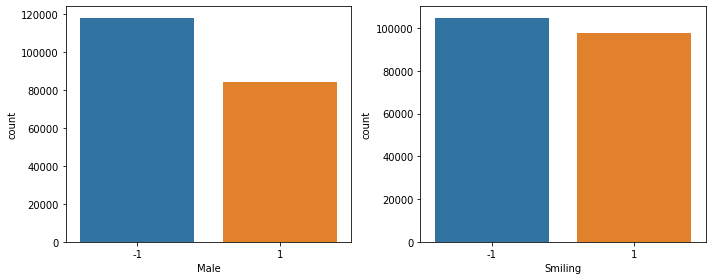

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (10,4))

sns.countplot(x = attri['Male'],ax = ax1)
sns.countplot(x = attri['Smiling'], ax =ax2)

clean()

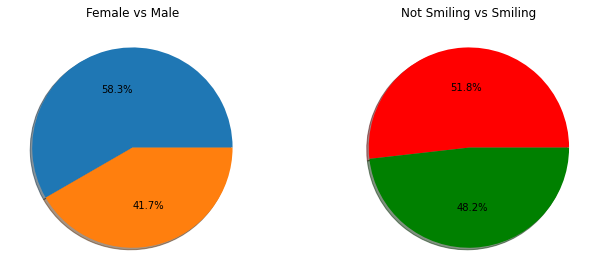

In [15]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, nrows = 1 ,figsize = (10,4))

ax1.pie(attri['Male'].value_counts(), autopct='%1.1f%%', shadow = True)
ax2.pie(attri['Smiling'].value_counts(), autopct='%1.1f%%', shadow = True, colors = ['Red','Green'])

ax1.set_title('Female vs Male')
ax2.set_title('Not Smiling vs Smiling')

clean()

In [19]:
img_path = os.getcwd() + '/img_align_celeba/img_align_celeba'
print(f'The number of images extracted are {len(os.listdir(img_path))}')

OSError: ignored

In [ ]:
attri['path'] = attri['image_id'].apply(lambda x: img_path + '/' + x)

In [ ]:
attri.head()

In [ ]:
def plot_random_batch(n, df, feature, path):
  sample_df = df[[path,feature]].copy()
  sample_df = sample_df.sample(n)
  
  for num, x in enumerate(sample_df.values):
    img = load_img(sample_df.iloc[num][0], target_size = (224,224))
    plt.subplot(6,6,num+1)
    plt.xlabel(sample_df.iloc[num][1])
    plt.imshow(img)
    
  plt.gcf().set_size_inches(15, 15)
  plt.tight_layout()
  plt.show()

In [ ]:
plot_random_batch(18,attri, 'Male','path')

In [ ]:
plot_random_batch(18,attri, 'Smiling','path')

# Smile Detection

### Splitting the Data:

Notes:
1. In evaluation status, "0" represents training image, "1" represents validation image, "2" represents testing image;
2. Identities of face images are NOT overlapped within this dataset partition;

In [ ]:
smile_df = attri.copy()
smile_df = gender_df.drop('Male',axis =1)

In [ ]:
smile_df.head()

In [ ]:
split_df = pd.read_csv('list_eval_partition.csv')

In [ ]:
display(split_df.head())

image_id  partition
0  000001.jpg          0
1  000002.jpg          0
2  000003.jpg          0
3  000004.jpg          0
4  000005.jpg          0

In [ ]:
display(split_df.tail())

image_id  partition
202594  202595.jpg          2
202595  202596.jpg          2
202596  202597.jpg          2
202597  202598.jpg          2
202598  202599.jpg          2

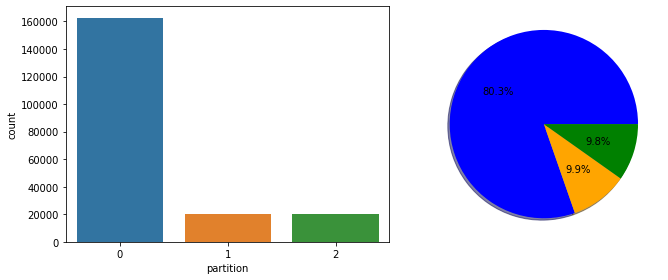

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (10,4))

sns.countplot(x = split_df['partition'], ax = ax1)
ax2.pie(split_df['partition'].value_counts(), autopct='%1.1f%%', shadow = True, colors = ['Blue','Orange','Green'])

clean()

In [ ]:
smile_df = pd.concat([smile_df, split_df], axis = 1,)
smile_df.head()

image_id  Male  ...    image_id partition
0  000001.jpg    -1  ...  000001.jpg         0
1  000002.jpg    -1  ...  000002.jpg         0
2  000003.jpg     1  ...  000003.jpg         0
3  000004.jpg    -1  ...  000004.jpg         0
4  000005.jpg    -1  ...  000005.jpg         0

[5 rows x 5 columns]

In [ ]:
smile_df = smile_df.loc[:,~smile_df.columns.duplicated()] # remove duplicates

In [ ]:
smile_df.head()

image_id  ...  partition
0  000001.jpg  ...          0
1  000002.jpg  ...          0
2  000003.jpg  ...          0
3  000004.jpg  ...          0
4  000005.jpg  ...          0

[5 rows x 4 columns]

In [ ]:
smile_df['Male'] = smile_df['Male'].apply(lambda x: 'Male' if x == 1 else 'Female')

In [ ]:
gender_df.head()

image_id  ... partition
0  000001.jpg  ...         0
1  000002.jpg  ...         0
2  000003.jpg  ...         0
3  000004.jpg  ...         0
4  000005.jpg  ...         0

[5 rows x 4 columns]

In [ ]:
train_gender_df = gender_df[gender_df['partition'] == 0]
valid_gender_df = gender_df[gender_df['partition'] == 1]
test_gender_df = gender_df[gender_df['partition'] == 2]

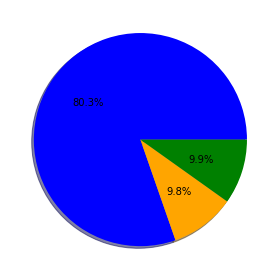

In [ ]:
values = [len(train_gender_df), len(valid_gender_df),len(test_gender_df)]
plt.pie(values, autopct='%1.1f%%', shadow = True, colors = ['Blue','Orange','Green'])

clean()

In [ ]:
print(train_gender_df.shape)
print(valid_gender_df.shape)
print(test_gender_df.shape)

(162770, 4)
(19867, 4)
(19962, 4)


## ResNet50:

### ResNet50 Loading the Generators:

In [ ]:
batch_size = 32
size = 224

In [ ]:
def batch_shape(generator):
  for data_batch, labels_batch in generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_gender_df, 
    x_col='path',
    y_col='Male',
    target_size=(size,size),
    class_mode='categorical',
    batch_size=batch_size)

Found 162770 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

validation_generator = validation_datagen.flow_from_dataframe(
    valid_gender_df, 
    x_col='path',
    y_col='Male',
    target_size=(size,size),
    class_mode='categorical',
    batch_size=batch_size)

Found 19867 validated image filenames belonging to 2 classes.


In [ ]:
batch_shape(train_generator)

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 2)


In [ ]:
batch_shape(validation_generator)

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 2)


In [ ]:
first_batch = next(iter(train_generator))

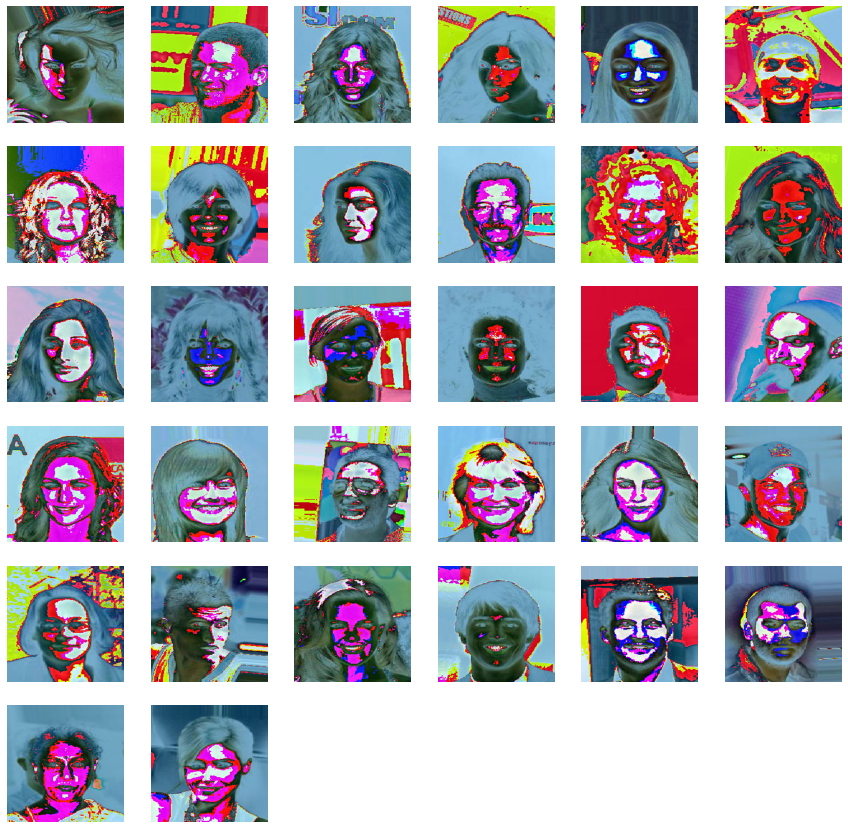

In [ ]:
for num, x in enumerate(first_batch[0]):
    img = x
    plt.subplot(6,6,num+1)
    plt.axis('off')
    #plt.imshow(img)
    plt.imshow((img * 255).astype(np.uint8))

plt.gcf().set_size_inches(15, 15)

### ResNet50 Model:

In [ ]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top = False)

94773248/94765736 [==============================] - 2s 0us/step


In [ ]:
print(f"The number of layers in the network are: {len(base_model.layers)}")

The number of layers in the network are: 175


In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
preds = tf.keras.layers.Dense(2, activation ='softmax')(x)

In [ ]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=preds)
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
for layer in model.layers[:175]:
  layer.trainable = False

In [ ]:
for layer in model.layers[175:]:
  layer.trainable = True

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, 
                              epochs = 3, validation_data = validation_generator)

Epoch 1/3
5086/5086 [==============================] - 737s 145ms/step - loss: 0.1494 - accuracy: 0.9421 - val_loss: 0.1173 - val_accuracy: 0.9536
Epoch 2/3
5086/5086 [==============================] - 702s 138ms/step - loss: 0.1193 - accuracy: 0.9536 - val_loss: 0.1129 - val_accuracy: 0.9592
Epoch 3/3
5086/5086 [==============================] - 683s 134ms/step - loss: 0.1073 - accuracy: 0.9581 - val_loss: 0.0961 - val_accuracy: 0.9612


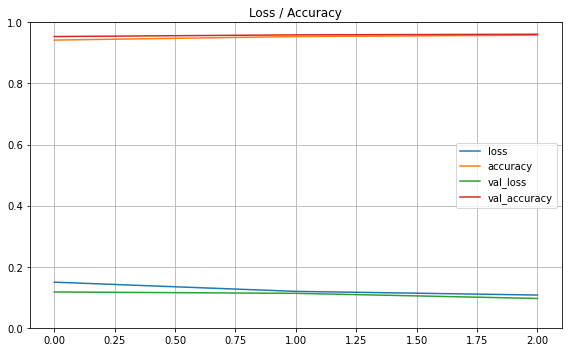

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.title('Loss / Accuracy')

plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]

plt.tight_layout()
plt.show()

### Test ResNet50:

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())

In [ ]:
label_map

{0: 'Female', 1: 'Male'}

In [ ]:
test_generator = validation_datagen.flow_from_dataframe(
    test_gender_df,
    x_col='path',
    y_col=None,
    class_mode=None,
    target_size=(size,size),
    batch_size=batch_size,
    shuffle=False)

Found 19962 validated image filenames.


In [ ]:
predictions = model.predict(test_generator)

In [ ]:
test_gender_df = test_gender_df.copy()
test_gender_df['labels'] = np.argmax(predictions, axis =-1)
test_gender_df['labels'] = test_gender_df['labels'].replace(label_map)

In [ ]:
test_gender_df['Male'].value_counts()

Female    12247
Male       7715
Name: Male, dtype: int64

In [ ]:
test_gender_df['labels'].value_counts()

Female    12111
Male       7851
Name: labels, dtype: int64

In [ ]:
test_gender_df['correct'] = test_gender_df.apply(lambda x: x['Male'] == x['labels'], axis =1)

In [ ]:
test_gender_df.head()

image_id    Male  ...  labels  correct
182637  182638.jpg  Female  ...  Female     True
182638  182639.jpg  Female  ...  Female     True
182639  182640.jpg  Female  ...  Female     True
182640  182641.jpg  Female  ...  Female     True
182641  182642.jpg  Female  ...  Female     True

[5 rows x 6 columns]

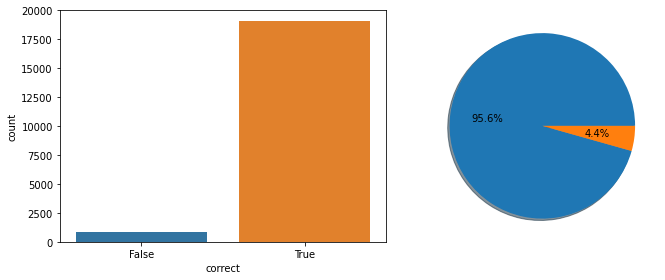

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, nrows =1, figsize = (10,4))

sns.countplot(x = test_gender_df['correct'],ax =ax1)
ax2.pie(test_gender_df['correct'].value_counts(), autopct='%1.1f%%', shadow = True)

clean()

In [ ]:
sample_df = test_gender_df.sample(16)

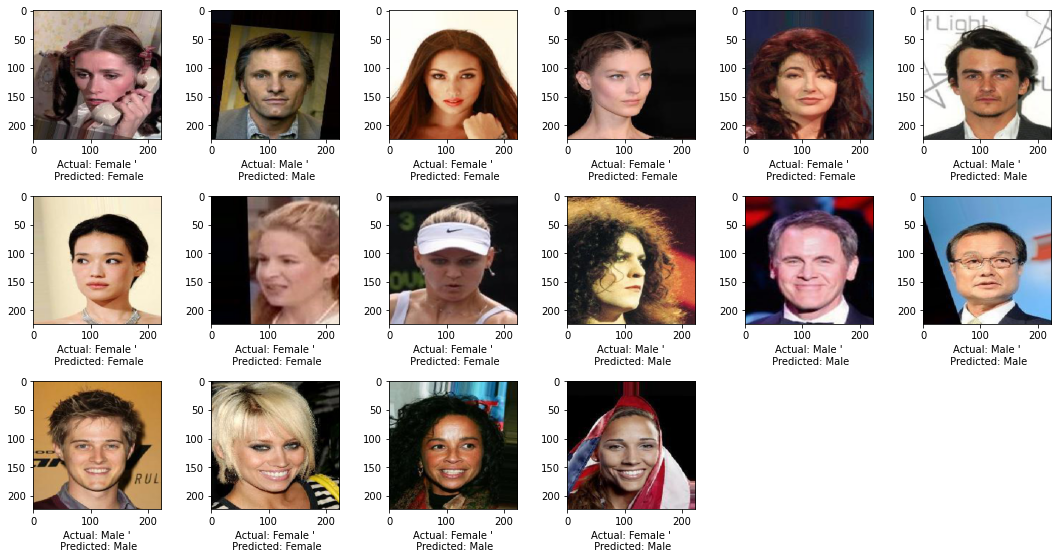

In [ ]:
for num, x in enumerate(sample_df.values):
    img = load_img(sample_df.iloc[num][2], target_size = (224,224))
    plt.subplot(6,6,num+1)
    plt.xlabel(f"Actual: {sample_df.iloc[num][1]} '\n Predicted: {sample_df.iloc[num][4]}")
    plt.imshow(img)

plt.gcf().set_size_inches(15, 15)
clean()

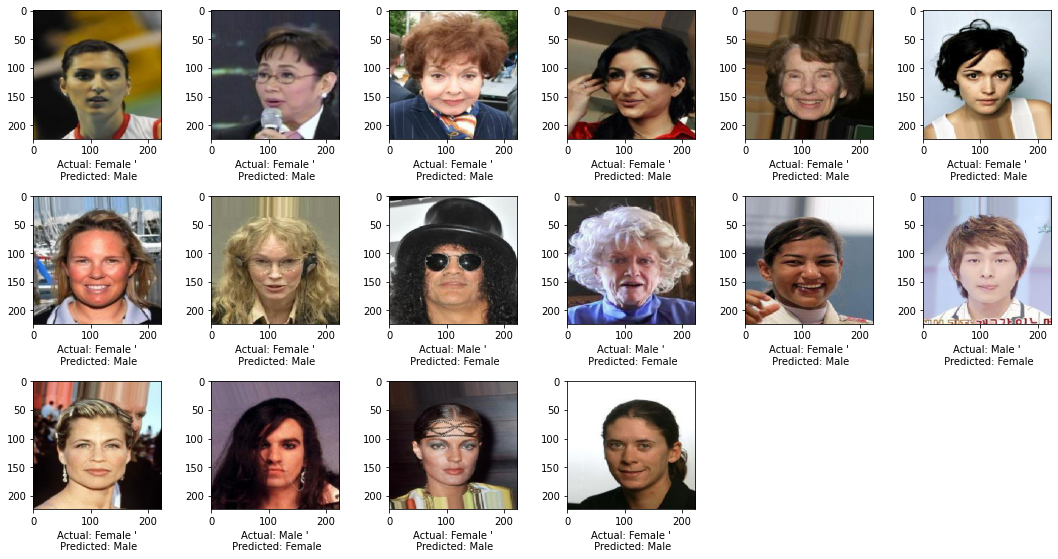

In [ ]:
# Plot some of my errors

errors = test_gender_df[test_gender_df['correct'] == False]
errors_sample = errors.sample(16)

for num, x in enumerate(errors_sample.values):
    img = load_img(errors_sample.iloc[num][2], target_size = (224,224))
    plt.subplot(6,6,num+1)
    plt.xlabel(f"Actual: {errors_sample.iloc[num][1]} '\n Predicted: {errors_sample.iloc[num][4]}")
    plt.imshow(img)

plt.gcf().set_size_inches(15, 15)
clean()

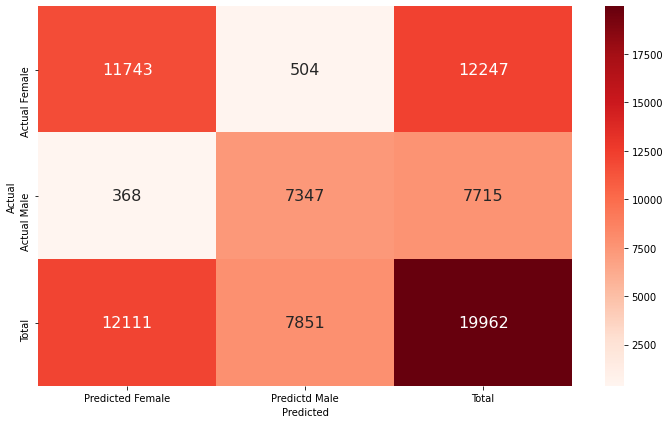

In [ ]:
confusion_matrix = pd.crosstab(test_gender_df['Male'], test_gender_df['labels'], rownames=['Actual'], colnames=['Predicted'],margins = True)

fig, ax = plt.subplots(figsize = (10,6))

sns.heatmap(confusion_matrix,annot = True, fmt ='d',annot_kws={"size": 16}, 
            xticklabels = ['Predicted Female','Predictd Male','Total'], yticklabels =['Actual Female', 'Actual Male','Total'],cmap ='Reds')

plt.tight_layout()
plt.show()

In [ ]:
resnet50_gender = model.save('resnet50_gender.h5')

In [ ]:
os.listdir(os.getcwd())

['celeba.zip',
 'Facial_Classification.ipynb',
 'img_align_celeba',
 'list_attr_celeba.csv',
 'list_bbox_celeba.csv',
 'list_eval_partition.csv',
 'list_landmarks_align_celeba.csv',
 'resnet50_gender.h5']

## VGG16:

### VGG16 Loading the Generators:

In [ ]:
batch_size = 32
size = 224

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    train_gender_df, 
    x_col='path',
    y_col='Male',
    target_size=(size,size),
    class_mode='categorical',
    batch_size=batch_size)

Found 162770 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

validation_generator = validation_datagen.flow_from_dataframe(
    valid_gender_df, 
    x_col='path',
    y_col='Male',
    target_size=(size,size),
    class_mode='categorical',
    batch_size=batch_size)

Found 19867 validated image filenames belonging to 2 classes.


In [ ]:
batch_shape(train_generator)

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 2)


In [ ]:
batch_shape(validation_generator)

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 2)


In [ ]:
first_batch = next(iter(train_generator))

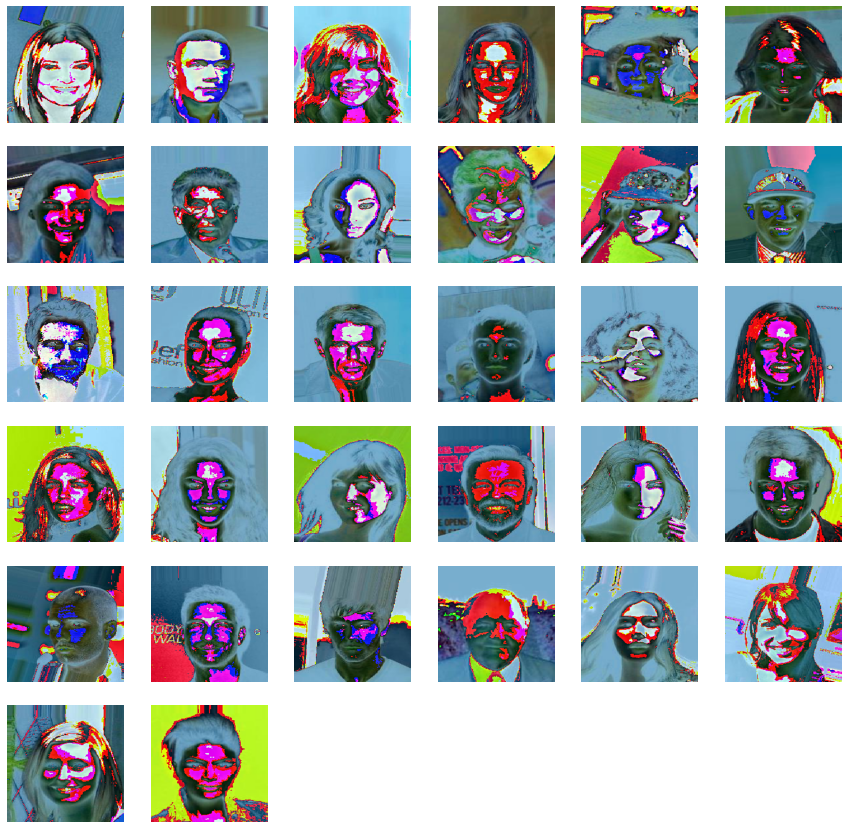

In [ ]:
for num, x in enumerate(first_batch[0]):
    img = x
    plt.subplot(6,6,num+1)
    plt.axis('off')
    #plt.imshow(img)
    plt.imshow((img * 255).astype(np.uint8))

plt.gcf().set_size_inches(15, 15)

### VGG16 Model:

In [ ]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top = False)

In [ ]:
print(f"The number of layers in the network are: {len(base_model.layers)}")

The number of layers in the network are: 19


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)

preds = tf.keras.layers.Dense(2, activation ='softmax')(x)

In [ ]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=preds)
print(model.summary())

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128) 

In [ ]:
for layer in model.layers[:17]:
  layer.trainable = False

In [ ]:
for layer in model.layers[17:]:
  layer.trainable = True

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, 
                              epochs = 3, validation_data = validation_generator)

Epoch 1/3
5086/5086 [==============================] - 786s 154ms/step - loss: 0.1081 - accuracy: 0.9608 - val_loss: 0.0762 - val_accuracy: 0.9719
Epoch 2/3
5086/5086 [==============================] - 784s 154ms/step - loss: 0.0760 - accuracy: 0.9732 - val_loss: 0.0621 - val_accuracy: 0.9755
Epoch 3/3
5086/5086 [==============================] - 784s 154ms/step - loss: 0.0637 - accuracy: 0.9778 - val_loss: 0.0599 - val_accuracy: 0.9788


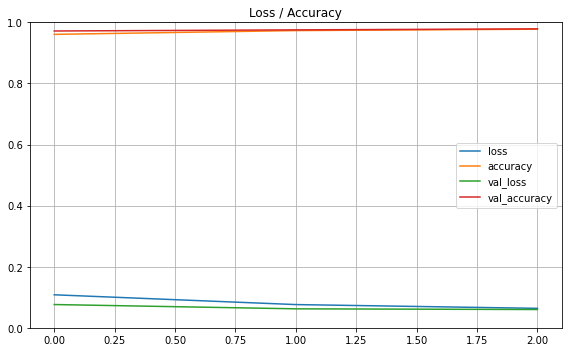

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.title('Loss / Accuracy')

plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]

plt.tight_layout()
plt.show()

### Test VGG16:

In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())

In [ ]:
test_generator = validation_datagen.flow_from_dataframe(
    test_gender_df,
    x_col='path',
    y_col=None,
    class_mode=None,
    target_size=(size,size),
    batch_size=batch_size,
    shuffle=False)

Found 19962 validated image filenames.


In [ ]:
predictions = model.predict(test_generator)

In [ ]:
test_gender_df['vgg_labels'] = np.argmax(predictions, axis =-1)
test_gender_df['vgg_labels'] = test_gender_df['vgg_labels'].replace(label_map)

In [ ]:
test_gender_df.head()

image_id    Male  ... correct  vgg_labels
182637  182638.jpg  Female  ...    True      Female
182638  182639.jpg  Female  ...    True      Female
182639  182640.jpg  Female  ...    True      Female
182640  182641.jpg  Female  ...    True      Female
182641  182642.jpg  Female  ...    True        Male

[5 rows x 7 columns]

In [ ]:
test_gender_df['Male'].value_counts()

Female    12247
Male       7715
Name: Male, dtype: int64

In [ ]:
test_gender_df['vgg_labels'].value_counts()

Female    12268
Male       7694
Name: vgg_labels, dtype: int64

In [ ]:
test_gender_df['vgg_correct'] = test_gender_df.apply(lambda x: x['Male'] == x['vgg_labels'], axis =1)

In [ ]:
test_gender_df.head()

image_id    Male  ... vgg_labels  vgg_correct
182637  182638.jpg  Female  ...     Female         True
182638  182639.jpg  Female  ...     Female         True
182639  182640.jpg  Female  ...     Female         True
182640  182641.jpg  Female  ...     Female         True
182641  182642.jpg  Female  ...       Male        False

[5 rows x 8 columns]

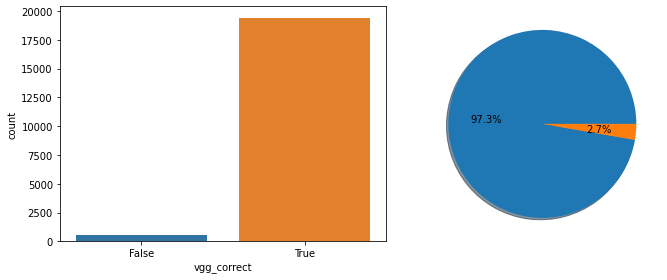

In [ ]:
fig, (ax1,ax2) = plt.subplots(ncols = 2, nrows =1, figsize = (10,4))

sns.countplot(x = test_gender_df['vgg_correct'],ax =ax1)
ax2.pie(test_gender_df['vgg_correct'].value_counts(), autopct='%1.1f%%', shadow = True)

clean()

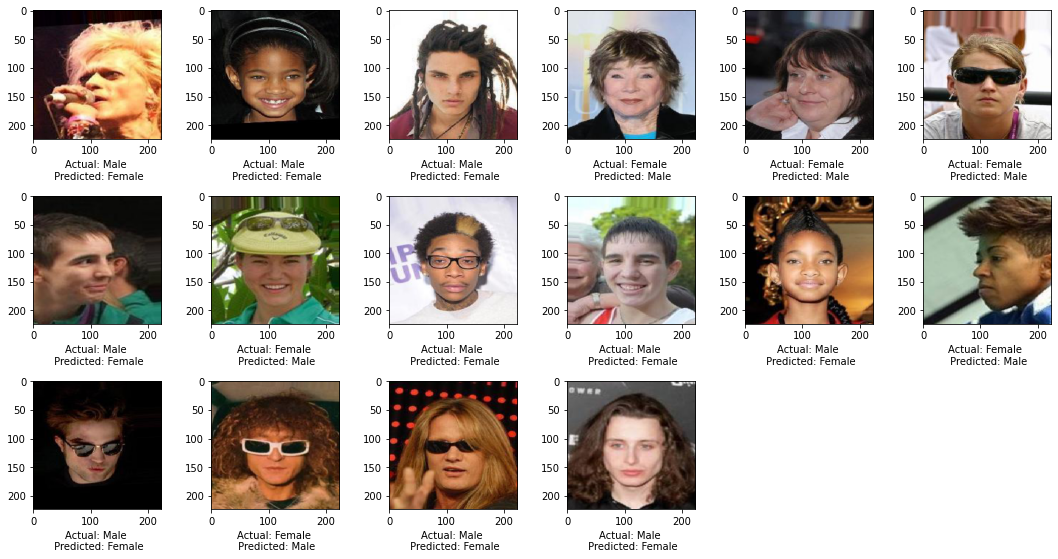

In [ ]:
# Plot some of my errors

errors = test_gender_df[test_gender_df['vgg_correct'] == False]
errors_sample = errors.sample(16)

for num, x in enumerate(errors_sample.values):
    img = load_img(errors_sample.iloc[num][2], target_size = (224,224))
    plt.subplot(6,6,num+1)
    plt.xlabel(f"Actual: {errors_sample.iloc[num][1]} \n Predicted: {errors_sample.iloc[num][6]}")
    plt.imshow(img)

plt.gcf().set_size_inches(15, 15)
clean()

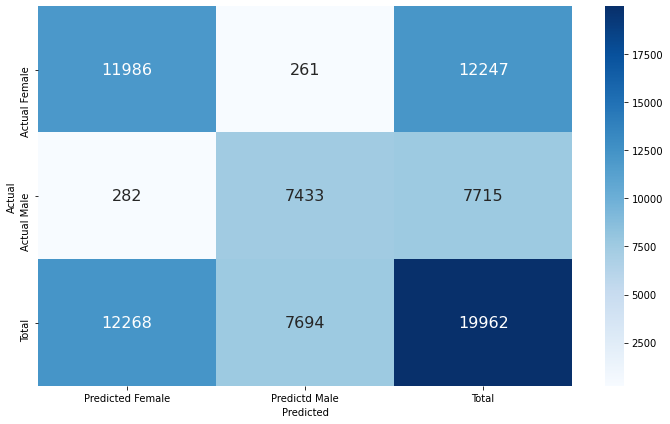

In [ ]:
confusion_matrix = pd.crosstab(test_gender_df['Male'], test_gender_df['vgg_labels'], rownames=['Actual'], colnames=['Predicted'],margins = True)

fig, ax = plt.subplots(figsize = (10,6))

sns.heatmap(confusion_matrix,annot = True, fmt ='d',annot_kws={"size": 16}, 
            xticklabels = ['Predicted Female','Predictd Male','Total'], yticklabels =['Actual Female', 'Actual Male','Total'],cmap ='Blues')

plt.tight_layout()
plt.show()

In [ ]:
vgg16_gender = model.save('vgg16_gender.h5')

In [ ]:
os.listdir(os.getcwd())

['celeba.zip',
 'Facial_Classification.ipynb',
 'img_align_celeba',
 'list_attr_celeba.csv',
 'list_bbox_celeba.csv',
 'list_eval_partition.csv',
 'list_landmarks_align_celeba.csv',
 'resnet50_gender.h5',
 'vgg16_gender.h5']

# Comparison:

In [ ]:
errors_res = test_gender_df[test_gender_df['correct'] == False]

In [ ]:
errors_vgg = test_gender_df[test_gender_df['vgg_correct'] == False]

In [ ]:
errors_res['correct'].value_counts()

False    872
Name: correct, dtype: int64

In [ ]:
errors_vgg['vgg_correct'].value_counts()

False    543
Name: vgg_correct, dtype: int64

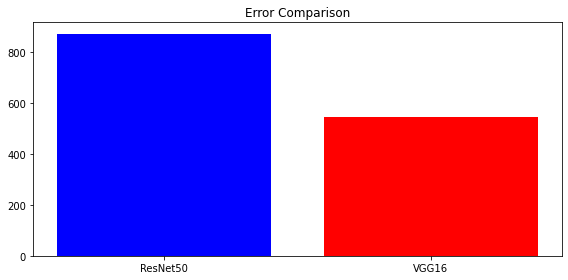

In [ ]:
x = ['ResNet50', 'VGG16']
y = [len(errors_res),errors_vgg]

fig, ax = plt.subplots(figsize = (8,4))

ax.bar(['ResNet50','VGG16'], height = [len(errors_res),len(errors_vgg)],color = ['Blue','Red'])
ax.set_title('Error Comparison')

clean()

In [ ]:
# load the resent model and predict to make the roc auc curve
from keras.models import load_model

resnet50_loaded = load_model('resnet50_gender.h5')

In [ ]:
res_validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

res_test_generator = res_validation_datagen.flow_from_dataframe(
    test_gender_df,
    x_col='path',
    y_col=None,
    class_mode=None,
    target_size=(size,size),
    batch_size=batch_size,
    shuffle=False)

Found 19962 validated image filenames.


In [ ]:
res_predictions = resnet50_loaded.predict(res_test_generator)

In [ ]:
fpr_res, tpr_res, thresholds_res = roc_curve(test_gender_df['Male'], np.argmax(res_predictions,axis=-1), pos_label = 'Male')

In [ ]:
fpr_vgg, tpr_vgg, thresholds_vgg = roc_curve(test_gender_df['Male'], np.argmax(predictions,axis=-1), pos_label = 'Male')

In [ ]:
auc_vgg = auc(fpr_vgg, tpr_vgg)
auc_res = auc(fpr_res, tpr_res)

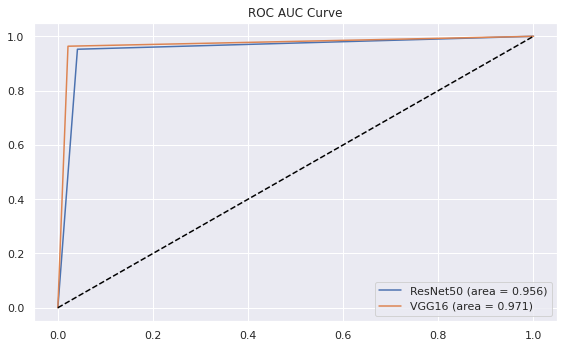

In [ ]:
sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize = (8,5))

plt.plot(fpr_res, tpr_res, label='ResNet50 (area = {:.3f})'.format(auc_res))
plt.plot(fpr_vgg, tpr_vgg, label='VGG16 (area = {:.3f})'.format(auc_vgg))

plt.plot([0, 1], [0, 1],linestyle='--',color ='black')

plt.title('ROC AUC Curve')
plt.legend()
clean()